<a href="https://colab.research.google.com/github/adisb01/COVID-Twitter-Analysis/blob/master/COVID_Twitter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
Despite the realization that our current situation is stressful and unfair, it is also a time in human history that will be studied for a long time due to the socioeconomic, psychological, and physical affects COVID has had on the entire world. One of the best ways to study any time period is to look at primary sources, direct accounts of people in history through their letters, artwork, architecture, and so on. And what better source of primary sources in the 21st century than Twitter? 


Twitter is home to billions of accounts of hundreds of millions of users, in easy to process, 250 character tweets, gold mine for anyone looking for data. Consequently, researchers have looked towards Tweet data to study everything from geographic differences in public health, to measuring how people cope with global crises (sounds familiar). Now, in an effort to study the world through Tweets once again, Kaggle has released a dataset comprised of **over 12 million tweets** with hashtags related to COVID-19 during March. 

My aim in this project is to analyze the data to understand the the current state of Tweet sentiment, timing, location, and length, and ultimately use all these features, and more to build a model that predicts how many favorites a Tweet has. Let's see what it takes to be popular on Twitter during times like these. 

The link to the dataset is here: 
https://www.kaggle.com/smid80/coronavirus-covid19-tweets

##Setup
Due to the massive amount of tweets involved in this project, we need to set up an AWS EMR cluster so we can run computations on multiple machines with Spark. 



In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic

In [ ]:
%%capture
%load_ext sparkmagic.magics 

In [ ]:
%spark add -s my_session1 -l python -u http://ec2-3-84-216-76.compute-1.amazonaws.com:8998

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
42,application_1588720070347_0043,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


##Handling CSVs
The tweet data starts off in 20 different CSV files. Reading from these 20 files and concatenating them each time is slow, so here we combine them and write them as a single JSON
file to an AWS S3 bucket we can later read from.

In [ ]:
import glob
file_paths= [i for i in glob.glob('/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/*.CSV'.format('csv'))]
file_paths

['/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-12 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-13 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-14 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-15 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-16 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-17 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-18 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-19 Coronavir

In [ ]:
tweet_csvs = []
hashtags_csv = "csv"
countries_csv = "csv"
for file in file_paths: 
  if '2020' in file: 
    tweet_csvs.append(file)
  elif 'Hashtags' in file:
    hashtags_csv = file
  else:
    countries_csv = file
tweet_csvs

['/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-12 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-13 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-14 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-15 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-16 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-17 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-18 Coronavirus Tweets.CSV',
 '/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/2020-03-19 Coronavir

In [ ]:
hashtags_csv

'/content/drive/My Drive/CIS 545 Final Project/coronavirus-covid19-tweets/Hashtags.CSV'

In [ ]:
tweet_df = pd.read_csv(tweet_csvs[0])
tweet_df.head(5)

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1235160526780416001,1163436067904618496,2020-03-04T11:09:52Z,Nanank08000089,#CoronaVirusIndonesia \n#CoronaBukaBorokRezim ...,Twitter for Android,NaN,NaN,NaN,False,False,797,0,NaN,NaN,NaN,21,142,NaN,2019-08-19T13:02:45Z,False,und
1,1235160526780416001,1163436067904618496,2020-03-04T11:09:52Z,Nanank08000089,#CoronaVirusIndonesia \n#CoronaBukaBorokRezim ...,Twitter for Android,NaN,NaN,NaN,False,False,797,0,NaN,NaN,NaN,21,142,NaN,2019-08-19T13:02:45Z,False,und
2,1235160546451873797,2255210942,2020-03-04T11:09:57Z,David_Mulroney,China’s wildlife trade via @SCMPgraphics http...,Twitter for iPad,NaN,NaN,NaN,False,False,1697,2,NaN,NaN,NaN,5666,2796,NaN,2013-12-20T16:14:18Z,False,en
3,1235160597475602432,366491737,2020-03-04T11:10:09Z,MarykeSchoonen,Proof that the media such as @CNN is unnecessa...,Twitter for iPhone,NaN,NaN,NaN,False,False,833,0,NaN,NaN,NaN,41,94,NaN,2011-09-02T08:22:14Z,False,en
4,1235160647614291968,61557732,2020-03-04T11:10:21Z,Arjit_Garg,Indians are a shitty breed of humans. With the...,Twitter for Android,NaN,NaN,NaN,False,False,1921,0,IN,"Greater Noida, India",city,486,50,NaN,2009-07-30T18:18:25Z,False,en


In [ ]:
%%spark 
hashtag_csv = 'Hashtags.CSV'
countries_csv = 'Countries.CSV'
tweet_csvs = ['2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV',
 '2020-03-12 Coronavirus Tweets.CSV',
 '2020-03-13 Coronavirus Tweets.CSV',
 '2020-03-14 Coronavirus Tweets.CSV',
 '2020-03-15 Coronavirus Tweets.CSV',
 '2020-03-16 Coronavirus Tweets.CSV',
 '2020-03-17 Coronavirus Tweets.CSV',
 '2020-03-18 Coronavirus Tweets.CSV',
 '2020-03-19 Coronavirus Tweets.CSV',
 '2020-03-20 Coronavirus Tweets.CSV',
 '2020-03-21 Coronavirus Tweets.CSV',
 '2020-03-22 Coronavirus Tweets.CSV',
 '2020-03-23 Coronavirus Tweets.CSV',
 '2020-03-24 Coronavirus Tweets.CSV',
 '2020-03-25 Coronavirus Tweets.CSV',
 '2020-03-26 Coronavirus Tweets.CSV',
 '2020-03-27 Coronavirus Tweets.CSV',
 '2020-03-28 Coronavirus Tweets.CSV']


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark

from pyspark.sql.types import *

tweet_schema = StructType(
    [
     StructField("status_id", StringType(), nullable = True), 
     StructField("user_id", StringType(), nullable = True), 
     StructField("created_at", StringType(), nullable = True ), 
     StructField("screen_name", StringType(), nullable = True), 
     StructField("text", StringType(), nullable = True), 
     StructField("source", StringType(), nullable = True), 
     StructField("reply_to_status_id", StringType(), nullable = True), 
     StructField("reply_to_user_id",StringType(), nullable = True), 
     StructField("reply_to_screen_name", StringType(), nullable = True), 
     StructField("is_quote", StringType(), nullable = True),
     StructField("is_retweet", StringType(), nullable = True), 
     StructField("favourites_count", StringType(), nullable = True), 
     StructField("retweet_count", StringType(), nullable = True), 
     StructField("country_code", StringType(), nullable = True), 
     StructField("place_full_name", StringType(), nullable = True), 
     StructField("place_type", StringType(), nullable = True),
     StructField("followers_count", StringType(), nullable = True), 
     StructField("friends_count", StringType(), nullable = True), 
     StructField("account_lang", StringType(), nullable = True), 
     StructField("account_created_at", StringType(), nullable = True ),
     StructField("verified", StringType(), nullable = True), 
     StructField("lang", StringType(), nullable = True), 
    ]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark 
import pandas as pd
bucket_path = "s3://cis545finalprojectdata/" 
path = bucket_path + tweet_csvs[0]
df = spark.read.format("csv").option("header", "true").option("multiline","true").load(path)
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- status_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- text: string (nullable = true)
 |-- source: string (nullable = true)
 |-- reply_to_status_id: string (nullable = true)
 |-- reply_to_user_id: string (nullable = true)
 |-- reply_to_screen_name: string (nullable = true)
 |-- is_quote: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- favourites_count: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- place_full_name: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- followers_count: string (nullable = true)
 |-- friends_count: string (nullable = true)
 |-- account_lang: string (nullable = true)
 |-- account_created_at: string (nullable = true)
 |-- verified: string (nullable = true)
 |-- lang: string (nullable = true)

In [ ]:
%%spark 
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+--------------------+----------+---------------+-------------+------------+--------------------+--------+----+
|          status_id|            user_id|          created_at|   screen_name|                text|             source|reply_to_status_id|reply_to_user_id|reply_to_screen_name|is_quote|is_retweet|favourites_count|retweet_count|country_code|     place_full_name|place_type|followers_count|friends_count|account_lang|  account_created_at|verified|lang|
+-------------------+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+--------------------+----------+---------------+-------------

In [ ]:
%%spark 
import pandas as pd
from pyspark.sql import SQLContext
sc = spark.sparkContext

tweet_sdf = sqlContext.createDataFrame(sc.emptyRDD(), StructType([]))
tweet_counts = []
num_tweets = 0
bucket_path = "s3://cis545finalprojectdata/" 
for file_path in tweet_csvs:
  path = bucket_path + file_path
  sdf = spark.read.format("csv").option("header", "true").option("multiline","true").load(path)
  num = sdf.count()
  num_tweets += num
  tweet_counts.append(num)
  if tweet_sdf.count() == 0:
    tweet_sdf = sdf
  else:
    tweet_sdf = tweet_sdf.unionAll(sdf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

setting up first tweet_sdf
appending sdf
size is now 1073988
appending sdf
size is now 2112620
appending sdf
size is now 2599860
appending sdf
size is now 3086161
appending sdf
size is now 3727167
appending sdf
size is now 4602033
appending sdf
size is now 5257941
appending sdf
size is now 6155844
appending sdf
size is now 6952863
appending sdf
size is now 7879343
appending sdf
size is now 8614578
appending sdf
size is now 9306255
appending sdf
size is now 9959540
appending sdf
size is now 10680138
appending sdf
size is now 11609436
appending sdf
size is now 12308102
appending sdf
size is now 12921416
Total number of tweets: 12921416

In [ ]:
%%spark 
tweet_sdf.show(4)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+---------------+----------+---------------+-------------+------------+--------------------+--------+----+
|          status_id|            user_id|          created_at|   screen_name|                text|             source|reply_to_status_id|reply_to_user_id|reply_to_screen_name|is_quote|is_retweet|favourites_count|retweet_count|country_code|place_full_name|place_type|followers_count|friends_count|account_lang|  account_created_at|verified|lang|
+-------------------+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----------------+--------------------+--------+----------+----------------+-------------+------------+---------------+----------+---------------+-------------+------------+-

In [ ]:
%%spark
tweet_sdf.schema

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

StructType(List(StructField(status_id,StringType,true),StructField(user_id,StringType,true),StructField(created_at,StringType,true),StructField(screen_name,StringType,true),StructField(text,StringType,true),StructField(source,StringType,true),StructField(reply_to_status_id,StringType,true),StructField(reply_to_user_id,StringType,true),StructField(reply_to_screen_name,StringType,true),StructField(is_quote,StringType,true),StructField(is_retweet,StringType,true),StructField(favourites_count,StringType,true),StructField(retweet_count,StringType,true),StructField(country_code,StringType,true),StructField(place_full_name,StringType,true),StructField(place_type,StringType,true),StructField(followers_count,StringType,true),StructField(friends_count,StringType,true),StructField(account_lang,StringType,true),StructField(account_created_at,StringType,true),StructField(verified,StringType,true),StructField(lang,StringType,true)))

In [ ]:
%%spark
path = bucket_path + "tweets.json"
tweet_sdf.write.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Combined Data
Now that all of the large CSV files have been concatenated into one JSON file in an S3 bucket, we can simply create a Spark dataframe by loading from this JSON file. 

In [ ]:
%%spark 
path = "s3://cis545finalprojectdata/tweets.json" 
raw_tweet_sdf = spark.read.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
raw_tweet_sdf.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+------------+--------------------+----------------+---------------+-------------+--------+----------+----+---------------+----------+--------------------+------------------+----------------+-------------+--------------+-------------------+-------------------+--------------------+-------------------+--------+
|  account_created_at|account_lang|country_code|          created_at|favourites_count|followers_count|friends_count|is_quote|is_retweet|lang|place_full_name|place_type|reply_to_screen_name|reply_to_status_id|reply_to_user_id|retweet_count|   screen_name|             source|          status_id|                text|            user_id|verified|
+--------------------+------------+------------+--------------------+----------------+---------------+-------------+--------+----------+----+---------------+----------+--------------------+------------------+----------------+-------------+--------------+-------------------+-------------------+----------------

In [ ]:
%%spark 
raw_tweet_sdf.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12921416

In [ ]:
%%spark 
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
raw_tweet_sdf.createOrReplaceTempView("raw_tweets")
bucket_path = "s3://cis545finalprojectdata/" 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#Exploratory Data Analysis
We now have a single dataframe containing data for **over 12 million tweets!** This is a lot to take in, so here, we will attempt to extract and analyze larger trends and characteristics of the data at hand to get a better idea of what we're working with. 


##Basic Characteristics
First, let's analyze the distributions of some basic features of the tweets such as the number of favorites, retweets, characters, mentions, and hashtags. Since these values can all take on a wide range of values, we can take their logs to reduce the range and thus also make less susceptible to instability issues when loading it into the models.

However, once we take the logs of the data, they become decimal numbers and there is no easy way to aggregate the data into a smaller dataframe. This is neccessary because we need to convert our data to a Pandas dataframe in order to plot the data and visualize it. Thus, we will take a random selection of around 4 million tweets and do our analysis from there. 

In [ ]:
%%spark 
import numpy as np

#randomly sampling 30% of data and converting to correct data types for log calcs
subset_tweets_sdf = raw_tweet_sdf.sample(False, .3, 1)

subset_tweets_sdf['favourites_count'].cast(IntegerType())
subset_tweets_sdf['followers_count'].cast(IntegerType())
subset_tweets_sdf['friends_count'].cast(IntegerType())
subset_tweets_sdf['retweet_count'].cast(IntegerType())
subset_tweets_sdf.createOrReplaceTempView("subset_tweets_sdf")
subset_tweets_sdf.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+------------+--------------------+----------------+---------------+-------------+--------+----------+----+---------------+----------+--------------------+------------------+----------------+-------------+--------------+-------------------+-------------------+--------------------+-------------------+--------+
|  account_created_at|account_lang|country_code|          created_at|favourites_count|followers_count|friends_count|is_quote|is_retweet|lang|place_full_name|place_type|reply_to_screen_name|reply_to_status_id|reply_to_user_id|retweet_count|   screen_name|             source|          status_id|                text|            user_id|verified|
+--------------------+------------+------------+--------------------+----------------+---------------+-------------+--------+----------+----+---------------+----------+--------------------+------------------+----------------+-------------+--------------+-------------------+-------------------+----------------

In [ ]:
%%spark
#get retweet data
q = """
SELECT retweet_count, favourites_count
FROM subset_tweets_sdf
WHERE retweet_count IS NOT NULL 
"""
rt_favs_sdf = spark.sql(q)
rt_favs_sdf.show(5)
rt_favs_df = rt_favs_sdf.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+----------------+
|retweet_count|favourites_count|
+-------------+----------------+
|            0|             797|
|            2|            1697|
|            0|             833|
|            4|            8074|
|            0|             245|
+-------------+----------------+
only showing top 5 rows

In [ ]:
%%spark 
import numpy as np

#plot a scatterplot
rt_favs_df['retweet_count'] = rt_favs_df['retweet_count'].astype(int)
rt_favs_df['retweet_count'] = pd.to_numeric(rt_favs_df['retweet_count'], errors='coerce')
rt_favs_df['retweet_count'] = rt_favs_df['retweet_count'].dropna()
rt_favs_df['retweet_log'] = np.log(rt_favs_df['retweet_count'])
rt_favs_df['retweet_log'] = rt_favs_df['retweet_log'].dropna()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark 

n_bins= 10
plt.hist(rt_favs_df['retweet_log'], n_bins, histtype='step', stacked=True, fill = True)
plt.title('Histogram of Retweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Retweets')

%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
range parameter must be finite.
Traceback (most recent call last):
  File "/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py", line 2610, in hist
    if data is not None else {}), **kwargs)
  File "/usr/local/lib64/python3.6/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/usr/local/lib64/python3.6/site-packages/matplotlib/axes/_axes.py", line 6649, in hist
    m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
  File "/usr/local/lib64/python3.6/site-packages/numpy/lib/function_base.py", line 670, in histogram
    'range parameter must be finite.')
ValueError: range parameter must be finite.



###Hashtags
Now, let's try to see what the distribution of hashtags is like in our data. Note that most posts have 0 hastags, so that will definitely skew our distribution. 

In [ ]:
%%spark 
#get number of hashtags
import re 

def get_num_hashtags(text): 
  tags = re.findall("[#]\w+", text)
  return len(tags)

spark.udf.register("GET_NUM_HASHTAGS", get_num_hashtags, IntegerType())
q = """
SELECT GET_NUM_HASHTAGS(text) as num_hashtags, favourites_count
FROM subset_tweets_sdf
WHERE text IS NOT NULL AND favourites_count IS NOT NULL
"""
tags_favs_sdf = spark.sql(q)
tags_favs_sdf.show(5)
tags_favs_sdf.createOrReplaceTempView("tags_favs_sdf")
tags_favs_df = tags_favs_sdf.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----------------+
|num_hashtags|favourites_count|
+------------+----------------+
|           4|             797|
|           8|            1697|
|           5|             833|
|           2|            8074|
|           6|             245|
+------------+----------------+
only showing top 5 rows

In [ ]:
%%spark 
#scale data with log
tags_favs_df['hashtags_log'] = np.log(tags_favs_df['num_hashtags'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/local/lib64/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)

In [ ]:
%%spark 
#plot line for hashtags vs av_fav_count
plt.clf()
plt.title("Hashtags vs Favorite Count")
plt.plot(tags_favs_df.hashtags_log, tags_favs_df.favourites_count, '.-')
plt.xlabel('Number of Hashtags')
plt.ylabel("Average Number of Favorites")
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0, 0.5, 'Average Number of Favorites')

In [ ]:
%%spark 
#plot histogram? 

###Mentions
Now, let's look at distribution of the number of mentions over the tweets. Note that once again, most tweets have 0 mentions so this will skew the distribution. 

In [ ]:
%%spark 
#get number of mentions

def get_num_mentions(text): 
  mentions = re.findall("[@]\w+", text)
  return len(mentions)

spark.udf.register("GET_NUM_MENTIONS", get_num_mentions, IntegerType())
q = """
SELECT GET_NUM_MENTIONS(text) as num_mentions, favourites_count
FROM subset_tweets_sdf
WHERE text IS NOT NULL
"""
mentions_favs_sdf = spark.sql(q)
mentions_favs_sdf.show(5)
# path = bucket_path + "mentions_and_favs.json"
# mentions_favs_sdf.write.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----------------+
|num_mentions|favourites_count|
+------------+----------------+
|           0|             797|
|           0|             797|
|           1|            1697|
|           1|             833|
|           0|            1921|
+------------+----------------+
only showing top 5 rows

###Length
Now, let's look at how many characters these tweets will have. There isn't much insight into this field, so it will be interesting to see what the result is. 

In [ ]:
%%spark 
#get number of characters in actual tweet
def clean_text(text): 
  text = re.sub(r'@[A-Za-z0-]+', '', text) # remove @mentions
  text = re.sub(r'RT[\s]+', '', text) # remove RT from end of retweets
  text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
  return text

def get_num_chars(text):
  cleaned = clean_text(text)
  return len(cleaned)

spark.udf.register("GET_NUM_CHARS", get_num_chars, IntegerType())
q = """
SELECT GET_NUM_CHARS(text) as length, favourites_count
FROM subset_tweets_sdf
WHERE text IS NOT NULL
"""
lengths_favs_sdf = spark.sql(q)
lengths_favs_sdf.show(5)
lenghts_favs_df = lengths_favs_sdf.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----------------+
|length|favourites_count|
+------+----------------+
|    87|             797|
|    87|             797|
|   125|            1697|
|   237|             833|
|   195|            1921|
+------+----------------+
only showing top 5 rows


##When did people tweet? 
The tweets are from March 2020, but let's try to see how the tweets are distributed across the Month. Did the hype die down, or rise during this period? Note that since here we have a clear aggreagation function, there is no reason to downsample the data. 

In [ ]:
%%spark

q = """
SELECT EXTRACT(DAY FROM TO_DATE(created_at)) as day_posted, COUNT(*) AS num_tweets
FROM raw_tweets
WHERE created_at IS NOT NULL AND EXTRACT(MONTH FROM TO_DATE(created_at)) != 0
GROUP BY day_posted
ORDER BY day_posted
"""
days_sdf = spark.sql(q)
days_sdf.show()
days_sdf.createOrReplaceTempView('dates_sdf')
# path = bucket_path + "day_and_tweets.json"
# days_sdf.write.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+
|day_posted|num_tweets|
+----------+----------+
|         1|         1|
|         4|      7680|
|         5|     20142|
|         6|     14703|
|         7|     10183|
|         8|     10620|
|         9|     48478|
|        10|    155730|
|        11|    259247|
|        12|    497295|
|        13|    994594|
|        14|    465448|
|        15|    464384|
|        16|    612466|
|        17|    834932|
|        18|    626191|
|        19|    855831|
|        20|    758603|
|        21|    881939|
|        22|    700921|
+----------+----------+
only showing top 20 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

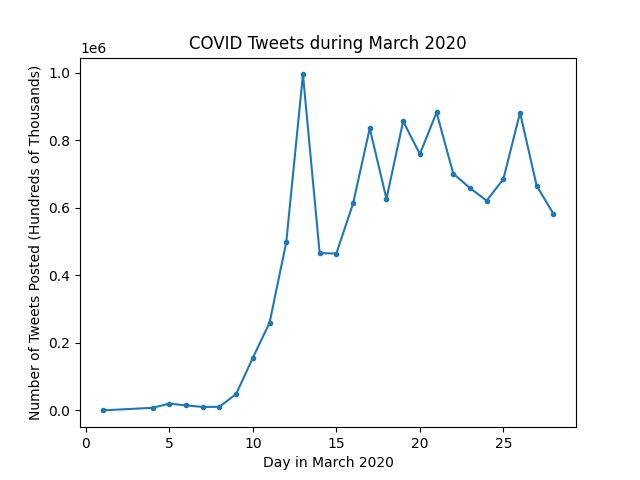

In [ ]:
%%spark 
days_df = days_sdf.toPandas()
plt.clf()
plt.title("COVID Tweets during March 2020")
plt.plot(days_df.day_posted, days_df.num_tweets, '.-')
plt.xlabel('Day in March 2020')
plt.ylabel("Number of Tweets Posted (Hundreds of Thousands)")
%matplot plt

Below is a depiction the daily cases worldwide from the Johns Hopkins Coronavirus Resource Center. As we can see, cases started really picking up near March end, but in our dataset, tweets didn't continue to increase in accordance, instead peaking around March 13. This is probably because the tweets in our dataset are exhaustive, but it could also be because people started having other things to worry about over Twitter

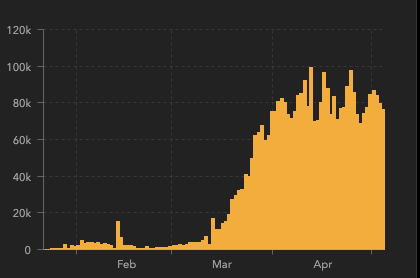

Let's also see if people post more often on certain days of the week 


In [ ]:
%%spark 

weekdays = { 
  1: 'Sunday', 
  2: 'Monday', 
  3: 'Tuesday', 
  4:'Wednesday', 
  5: 'Thursday', 
  6: 'Friday', 
  7: 'Saturday'
}

def get_weekday(date):
  weekday = date % 7
  if weekday == 0:
    return 7
  else:
    return weekday
spark.udf.register("GET_WEEKDAY", get_weekday, IntegerType())

q = """
SELECT GET_WEEKDAY(day_posted) as weekday_posted, SUM(num_tweets) as num_tweets
FROM dates_sdf
GROUP BY weekday_posted
ORDER BY weekday_posted
"""
weekdays_sdf = spark.sql(q)
weekdays_sdf.show()
# path = bucket_path + "weekday_and_tweets.json"
# lengths_favs_sdf.write.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+----------+
|weekday_posted|num_tweets|
+--------------+----------+
|             1|   1175926|
|             2|   1319156|
|             3|   1611513|
|             4|   1577666|
|             5|   2254524|
|             6|   2432006|
|             7|   1939615|
+--------------+----------+

In [ ]:
%%spark 
def get_weekday_name(num):
  return weekdays[num]

spark.udf.register("GET_WEEKDAY_NAME", get_weekday_name, StringType())
weekdays_sdf.createOrReplaceTempView("weekdays_sdf")

q = """
SELECT GET_WEEKDAY_NAME(weekday_posted) AS weekday, num_tweets
FROM weekdays_sdf
"""

weekdays_sdf = spark.sql(q)
weekdays_sdf.show()
weekdays_df = weekdays_sdf.toPandas()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+
|  weekday|num_tweets|
+---------+----------+
|   Sunday|   1175926|
|   Monday|   1319156|
|  Tuesday|   1611513|
|Wednesday|   1577666|
| Thursday|   2254524|
|   Friday|   2432006|
| Saturday|   1939615|
+---------+----------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

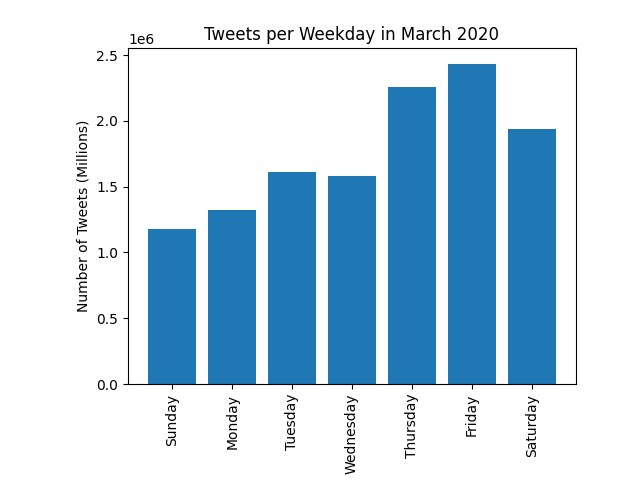

In [ ]:
%%spark 
plt.clf()
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.bar(weekdays_df.weekday, weekdays_df.num_tweets)
plt.ylabel('Number of Tweets (Millions)')
plt.xlabel('Weekday')
plt.xticks(rotation = 90)
plt.title('Tweets per Weekday in March 2020')
%matplot plt

We see that tweets rise up during the work week and decrease on the weekends. This could be due to the fact that people want to procrastinate from work and as they progress throughout the week, their stress builds, leading to more procrastination and tweeting. Or, it could be something entirely different. It would be fascinating to look at the overall number of tweets by day on Twitter and see how this distribution compares. 

##Where are people tweeting from? 
Another important fact to consider is not only when people are tweeting, but where they're tweeting from. The virus has affected different parts of the world, and let's see if this correlates to how many tweets are made from those places in the world. Note that our dataset doesn't have a valid country value for each tweet, so the total number of tweets below will be less than our 1.3 million. Furthermore, the tweet dataset only has country codes, so we will use a table that maps country codes to countries to make the data readable. Note that once again, we have a clear aggregation function so we will be able to use all of the data. 

In [ ]:
%%spark 
countries_sdf = spark.read.format("csv").option("header", "true").load("s3://cis545finalprojectdata/Countries.CSV")
countries_sdf.show(4)
countries_sdf.createOrReplaceTempView('countries_sdf')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------+
|      country|country_code|
+-------------+------------+
|         null|        null|
|  Afghanistan|          AF|
|Aland Islands|          AX|
|      Albania|          AL|
+-------------+------------+
only showing top 4 rows

### Worldwide
Here, we see the top 10 countries in terms of COVID tweet output. Unsurprisingly, USA has the most, having a large population, large access to technology, and the highest number of cases at the time. However, the rest of the countries are interesting. The UK doesn't have the second most cases, but it could just have a population with greater access to technology. It could also be because of countries Kaggle was looking at  

In [ ]:
%%spark
q = """
SELECT country_code, COUNT(*) as num_tweets
FROM raw_tweets
WHERE country_code IS NOT NULL
GROUP BY country_code
ORDER BY num_tweets DESC
"""
sdf1 = spark.sql(q)
sdf1.createOrReplaceTempView('sdf1')

q2 = """
SELECT countries_sdf.country AS country, sdf1.num_tweets as num_tweets
FROM sdf1
JOIN countries_sdf
ON sdf1.country_code == countries_sdf.country_code
LIMIT 10
"""
country_to_tweets_sdf = spark.sql(q2)
country_to_tweets_sdf.show(3)
country_to_tweets_df = country_to_tweets_sdf.toPandas()
# path = bucket_path + "country_and_tweets.json"
# country_to_tweets_sdf.write.json(path)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+
|            country|num_tweets|
+-------------------+----------+
|            Ukraine|       240|
|Republic of Croatia|       234|
|            Namibia|       221|
+-------------------+----------+
only showing top 3 rows

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

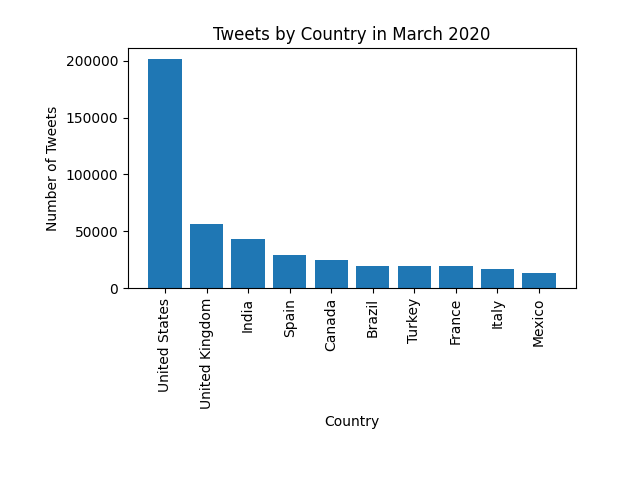

In [ ]:
%%spark 
plt.clf()
fig = plt.figure()
ax = fig.add_axes([.2,.4,.7,.5])
ax.bar(country_to_tweets_df.country, country_to_tweets_df.num_tweets)
plt.ylabel('Number of Tweets')
plt.xlabel('Country')
plt.xticks(rotation = 90)
plt.title('Tweets by Country in March 2020')
%matplot plt

###Within the United States
The USA is large and diverse, with the virus affecting different parts of the country at drastically varying magnitudes. Thus, it's also insightful to see how many tweets are being generated from each state in the USA and see how that correlates to the actual distribution of cases. This might not be fully accurate given that not all tweets have a "place_full_name" attribute which contains more specialized data about the tweets' geographic origin. Once again, the places with the number of highest tweets might just be because they have larger populations as opposed to the most COVID cases. 

In [ ]:
%%spark 
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark 
from pyspark.sql.types import *

def get_state(text): 
  regions = text.split(',')
  if len(regions) == 1:
    return "NONE"
  first = regions[0].strip()
  second = regions[1].strip()
  if second in states:
    return states[second]
  elif second == "USA":
    return first
  else: 
    return "NONE"

spark.udf.register("GET_STATE", get_state, StringType())
q = """
SELECT GET_STATE(place_full_name) as State, COUNT(*) as num_tweets
FROM raw_tweets
WHERE country_code == 'US' AND place_full_name IS NOT NULL 
AND GET_STATE(place_full_name) != 'NONE'
GROUP BY State
ORDER BY num_tweets DESC
LIMIT 10 
"""
state_tweets_sdf = spark.sql(q)
state_tweets_sdf.show()
state_tweets_df = state_tweets_sdf.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+----------+
|        State|num_tweets|
+-------------+----------+
|   California|     29013|
|     New York|     19909|
|      Florida|     16757|
|        Texas|     15973|
| Pennsylvania|      6581|
|     Illinois|      6461|
|         Ohio|      5762|
|      Georgia|      5718|
|Massachusetts|      5701|
|   Washington|      5059|
+-------------+----------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

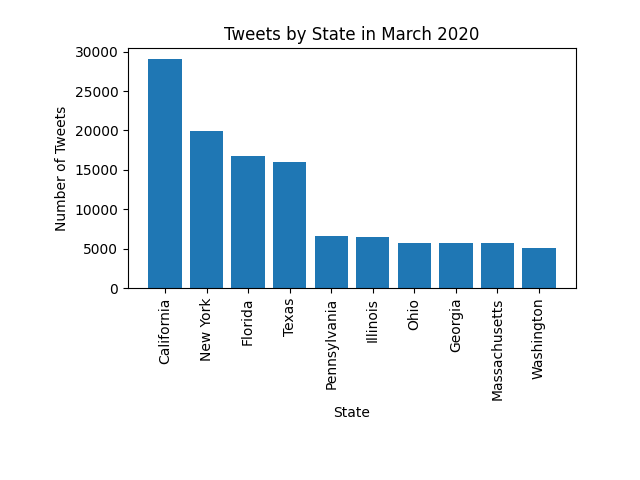

In [ ]:
%%spark 
#plot tweets by state
plt.clf()
fig = plt.figure()
ax = fig.add_axes([.2,.4,.7,.5])
ax.bar(state_tweets_df.State, state_tweets_df.num_tweets)
plt.ylabel('Number of Tweets')
plt.xlabel('State')
plt.xticks(rotation = 90)
plt.title('Tweets by State in March 2020')
%matplot plt

##What are people tweeting?
The pandemic is an event that has touched the lives of us all and has led to many different types of charged emotions. Using the python NLTK library (developed here at Penn!), we can analyze the sentiment of each of the tweets and look at the distribution. Note that a more positive index represents a more postive tweet, and similarly with negative index and a negative attitude. 

These computations did work but for some reason crashed. Evidence that it did at once work is in the Cleaning & Feature Engineering section under Word Vectorization where I left the outputs unchanged. 

In [ ]:
%%spark 

import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def clean_text(text): 
  text = re.sub(r'@[A-Za-z0-]+', '', text) # remove @mentions
  text = re.sub(r'RT[\s]+', '', text) # remove RT from end of retweets
  text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
  return text

def get_sentiment(text): 
  cleaned_text = clean_text(text)
  score = SentimentIntensityAnalyzer().polarity_scores(cleaned_text)
  return score['compound']

spark.udf.register("GET_SENTIMENT", get_sentiment, FloatType())

q = """
SELECT GET_SENTIMENT(text) AS sentiment
FROM subset_tweets_sdf
WHERE text IS NOT NULL
"""
sentiments_sdf = spark.sql(q)
sentiments_sdf.show(3)

KeyboardInterrupt: ignored

In [ ]:
%%spark 
#plot a histogram 
n_bins= 10
plt.hist(sentiments_df['sentiment'], n_bins, histtype='step', stacked=True, fill = True)
plt.title('Histogram of Tweet Sentiments')
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
%matplot plt

KeyboardInterrupt: ignored

#Modeling
Given all the information we have, let's now try to create a model that can predict the number of likes a tweet will have. Since we are inputting a set of features to predict a numeric value, tweets' favorited counts, we should use a linear regression model as was done in HW4. Lasso seemes especially useful for our case (mainly just the text) since a small number of features carry a lot of weight, and lasso would reduce overfitting. 

##Cleaning & Feature Engineering
The data is already mostly in the format we want, but let's go ahead and drop the columns we don't want such as status id, username of the user, account lang, and location data (most of the location data is missing). Furthemore, let's clean the tweet text so they don't include any mentions, hyperlinks, or RT tags as done before so the sentiment analysis works. We'll also want to tokenize the text and remove stopwords so that we can turn out tweet text into a vector later on. Finally, from the remaining tweets, let's drop any that have any null values. 

In [ ]:
%%spark 
from pyspark.sql.types import *
import nltk
import re
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#relevant functions again so I don't have to keep running all the cells before

def get_log(num):
  return np.log(int(num))

spark.udf.register("NP_LOG", get_log, FloatType())

def get_num_mentions(text): 
  mentions = re.findall("[@]\w+", text)
  return len(mentions)

spark.udf.register("GET_NUM_MENTIONS", get_num_mentions, IntegerType())

def get_num_hashtags(text): 
  tags = re.findall("[#]\w+", text)
  return len(tags)

spark.udf.register("GET_NUM_HASHTAGS", get_num_hashtags, IntegerType())

def get_weekday(date):
  weekday = date % 7
  if weekday == 0:
    return 7
  else:
    return weekday
spark.udf.register("GET_WEEKDAY", get_weekday, IntegerType())

def clean_text(text): 
  text = re.sub(r'@[A-Za-z0-]+', '', text) # remove @mentions
  text = re.sub(r'RT[\s]+', '', text) # remove RT from end of retweets
  text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks
  return text

def get_num_chars(text):
  cleaned = clean_text(text)
  return len(cleaned)

spark.udf.register("GET_NUM_CHARS", get_num_chars, IntegerType())


def get_sentiment(text): 
  cleaned_text = clean_text(text)
  score = SentimentIntensityAnalyzer().polarity_scores(cleaned_text)
  return score['compound']

spark.udf.register("GET_SENTIMENT", get_sentiment, FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function get_sentiment at 0x7f8fbd84d1e0>

In [ ]:
%%spark
#cast to correct data types
raw_tweet_sdf['favourites_count'].cast(IntegerType())
raw_tweet_sdf['followers_count'].cast(IntegerType())
raw_tweet_sdf['friends_count'].cast(IntegerType())
raw_tweet_sdf['retweet_count'].cast(IntegerType())

raw_tweet_sdf['verified'].cast(BooleanType())
raw_tweet_sdf['is_quote'].cast(BooleanType())
raw_tweet_sdf['is_retweet'].cast(BooleanType())
raw_tweet_sdf.createOrReplaceTempView('raw_tweets')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
#select only useful columns and add relevant features 
 
q = """
SELECT 
  status_id,
  EXTRACT(DAY FROM TO_DATE(created_at)) AS day_posted,
  (favourites_count) as fav_log, 
  followers_count), 
  friends_count),
  is_quote,
  is_retweet, 
  (retweet_count),
  text,
  (GET_NUM_CHARS(text)) as log_length,
  (GET_NUM_MENTIONS(text)) as log_mentions, 
  (GET_NUM_HASHTAGS(text)) as log_hashtags,
  GET_SENTIMENT(text) as sentiment,
  verified AS is_verified 
FROM raw_tweets
WHERE text IS NOT NULL AND created_at IS NOT NULL
"""
tweets_sdf = spark.sql(q)
tweets_sdf.show()
tweets_sdf.createOrReplaceTempView("tweets_useful_sdf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
"\nmismatched input ')' expecting <EOF>(line 6, pos 17)\n\n== SQL ==\n\nSELECT \n  status_id,\n  EXTRACT(DAY FROM TO_DATE(created_at)) AS day_posted,\n  (favourites_count) as fav_log, \n  followers_count), \n-----------------^^^\n  friends_count),\n  is_quote,\n  is_retweet, \n  (retweet_count),\n  text,\n  (GET_NUM_CHARS(text)) as log_length,\n  (GET_NUM_MENTIONS(text)) as log_mentions, \n  (GET_NUM_HASHTAGS(text)) as log_hashtags,\n  GET_SENTIMENT(text) as sentiment,\n  verified AS is_verified \nFROM raw_tweets\nWHERE text IS NOT NULL AND created_at IS NOT NULL\n"
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/session.py", line 767, in sql
    return DataFrame(self._jsparkSession.sql(sqlQuery), self._wrapped)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/lib/pyspark.zip/p

###Vectorizing
In order to put the data into our linear regression model, we must represent the tweet text in a numeric way. This can be accomplished by obtaining an average word vector for the tweet using the Word2Vec Library. This didn't end up working...

In [ ]:
%%spark 
#tokenize
from pyspark.ml.feature import RegexTokenizer
regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'text_token')
tweets_tokened_sdf = regexTokenizer.transform(tweets_sdf)
tweets_tokened_sdf.show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+----------------+---------------+-------------+--------+----------+-------------+--------------------+------+------------+------------+---------+-----------+--------------------+
|          status_id|day_posted|favourites_count|followers_count|friends_count|is_quote|is_retweet|retweet_count|                text|length|num_mentions|num_hashtags|sentiment|is_verified|          text_token|
+-------------------+----------+----------------+---------------+-------------+--------+----------+-------------+--------------------+------+------------+------------+---------+-----------+--------------------+
|1235160526780416001|         4|             797|             21|          142|   FALSE|     FALSE|            0|#CoronaVirusIndon...|    87|           0|           4|      0.0|      FALSE|[coronavirusindon...|
|1235160526780416001|         4|             797|             21|          142|   FALSE|     FALSE|            0|#CoronaVirusIndon...|    87|           0|  

In [ ]:
%%spark 
# remove stopwords
from pyspark.ml.feature import StopWordsRemover
swr = StopWordsRemover(inputCol = 'text_token', outputCol = 'text_sw_removed')

tweets_stop_rmv_sdf = swr.transform(tweets_tokened_sdf)
tweets_stop_rmv_sdf.show(3)

tweets_stop_rmv_sdf.createOrReplaceTempView("stops_rmv_sdf")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----------+----------------+---------------+-------------+--------+----------+-------------+--------------------+------+------------+------------+---------+-----------+--------------------+--------------------+
|          status_id|day_posted|favourites_count|followers_count|friends_count|is_quote|is_retweet|retweet_count|                text|length|num_mentions|num_hashtags|sentiment|is_verified|          text_token|     text_sw_removed|
+-------------------+----------+----------------+---------------+-------------+--------+----------+-------------+--------------------+------+------------+------------+---------+-----------+--------------------+--------------------+
|1235160526780416001|         4|             797|             21|          142|   FALSE|     FALSE|            0|#CoronaVirusIndon...|    87|           0|           4|      0.0|      FALSE|[coronavirusindon...|[coronavirusindon...|
|1235160526780416001|         4|             797|             21|       

Now, this is still too much data for Word2Vec to handle. We have 12 millions tweets each with multiple words which multiplied together is a lot of computations. Thus, let's only keep the top million occuring words and remove all the others that aren't very common so we can reduce our data down to something Word2Vec can work with. 


In [ ]:
%%spark 
weights = [1.0] * 100
list_dfs = tweets_stop_rmv_sdf.randomSplit(weights, 1)
list_dfs[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[status_id: string, day_posted: int, favourites_count: string, followers_count: string, friends_count: string, is_quote: string, is_retweet: string, retweet_count: string, text: string, length: int, num_mentions: int, num_hashtags: int, sentiment: float, is_verified: string, text_token: array<string>, text_sw_removed: array<string>]

In [ ]:
%%spark 
list_dfs[0].count()

An error was encountered:
Session 38 did not reach idle status in time. Current status is busy.


In [ ]:
%%spark 
#feed each piece of df into word2vec
from pyspark.ml.feature import Word2Vec
list_results = []
for df in list_dfs:
  word2vec = Word2Vec(vectorSize = 30, minCount = 5, inputCol = 'text_sw_removed', outputCol = 'result')
  model = word2vec.fit(df)
  result = model.transform(df)
  list_results.append(result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KeyboardInterrupt: ignored

In [ ]:
# for word in row.text_sw_removed:
#   if word in word_to_freq:
#     word_to_freq[word] = word_to_freq[word] + 1
#   elif word is not None:
#     word_to_freq[word] = 1
#   print(row.text_sw_removed)


# sorted_freq = sorted(word_to_freq.items(), key=lambda x: x[1], reverse=True)
# sorted_freq

IndentationError: ignored

In [ ]:
%%spark 

#get list of top words
words_limit = 15
words_kept = []
for i in range (words_limit):
  word = sorted_freq[i][0]
  words_kept.append(word)
words_kept

In [ ]:
%%spark 
#only keep common words in dataframe
def reduce_words(words_list):
  keep_list = []
  for word in words_list: 
    if word in words_kept:
      keep_list.append(word)
  return keep_list

spark.udf.register("REDUCE_WORDS", reduce_words)

q = """
SELECT 
  status_id,
  day_posted,
  weekday_posted
  favourites_count, 
  followers_count, 
  friends_count,
  is_quote,
  is_retweet, 
  retweet_count,
  length,
  num_hashtags,
  num_mentions,
  sentiment, 
  is_verified, 
  REDUCE_WORDS(text_sw_removed) as text_reduced
FROM stops_rmv_sdf
"""

tweets_reduced_sdf = spark.sql(q)

for row in tweets_reduced_sdf.rdd.collect():
    print(row.reduced_text)

##Modeling
We are going to try 3 different models of increasing complexity and see how they compare against each other. I got nowhere...

###Simple Model
In this, we will try to predict the number of favorites of a tweet by looking soley at its word_vector, sentiment, and number of followers the tweeter has. This should be enough to give a decent estimate.

###Better Model
Now, let's use all of our features for our feature vector and see how the model improves

###Final Model
Finally, let's use the last model but with PCA applied to it to see how it compares. PCA should help because dimensionality reduction reduces overfitting of training data and increases efficiency. 

#Challenges
Although frustrating, this project was also very enriching, and a decent amount of that is because I had to struggle and learn on my own at times. 

##Installing Libraries 
I wanted to run sentiment analysis on Tweet text so I turned toward NLTK. However, in order to install it, I had to find the right command to put in the bootstrap script. This took me to the deepest confines of stack exchange as there is a specific configuration so that nltk also automatically downloads all of its packages (as someone else on Piazza also discovered). 

I also struggled a lot with getting matplotlib to work. For it alone, I went to 3 OH sessions, asked questions on Piazza, and even tried to set up an AWS CLI on my computer so I could just write my smaller files to S3, download them, put them in drive, and plot them in the colab environment. Luckily, you came in clutch and saved me. 

##Loading the Data
I couldn't load the data directy into Pandas so I had to use Spark and set up an EMR cluster. And as I began doing that, I kept reading from the 20 CSV files realized it would be more efficient to just concatenate the data once. So I asked around and was led toward storing the combined data on an S3 bucket which took some getting used to. 

##Managing the Data
The biggest challenge with this project stemmed from the massive size of the dataset. Due to the fact it was not loadable into pandas, or sometimes not even into Spark functions, a lot had to be done to accomodate for this.
For example, I had to randomly select a subset of data so I could try to do EDA with it. Furthermore, certain functions would take too many computations and crash the EMR. A big example of this was with converting my text into a word vector using Word2Vec. I tried to solve this first by creating a word frequency map and and going back through the tokens and only keeping the top million words. After that gave me a weird error (which I posted on Piazza), I tried to move towards breaking the larger data into 100 smallers dataframes to run Word2Vec on but still got the same error. 

##Cleaning the Data
It was also very difficult to clean the data. For some reason, I was unable to properly clean in order to calculate the logs of metrics of interest. I tried using commands from homeworks before and lines from stack exchange, but for some reason I was unable to sort through everything, which led to a lack of data visualization and proper model preparation. 

#Future Direction

##Finishing the Model
The most obvious future direction for this would be to go ahead and finish the linear regression model with properly scaled data. It was disappointing to not have been able to complete this, and I will attempt to finish this on my own once I find a way to acquire more AWS credits so I can utilize EMR Clusters to run the Spark computations. 

##More data
Another future direction for this would be to simply look at more tweet data. Kaggle claims on the site the dataset was downloaded from that this is the first dataset in a series on datasets, as they will continue to look at the upcoming months. Although this would require patience, I think it would be fascinating to see how the tweets evolve overtime, especially in count and sentiment, as the pandemic progresses. Furthermore, as time progresses, the method for scraping tweets may improve and reduce unnatural imbalances in the data, such as the country of origin, or have filled in more missing values for features such as "place_full_name". The only downside to this is it would make the project even more difficult, but as I become more proficient at Big Data Analytics, it would be something fun to tackle. 

##Word Vectorization
Moving forward, it would also be good to be able to successfully implement word vectorization for the tweet text itself. These vectors contain a rich amount of information about the tweets, and it would be really cool to see how the model does with these vectors vs without. Trying to model without the vectors lost so much information. It would also be cool to try out different types of word vectorization algorithms, such as those that consider context within the sentence. 
